<center>
    <h1> ANN </h1>
</center>

In [33]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
from IPython.display import Audio

import noisereduce as nr
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [41]:
data_path = "../../data/audio-files/"

In [42]:
df = pd.read_csv("../../data/final_df.csv")
df.head()

,file_path,emotion
0,../../data/audio-files/S04_fear_peak_03.wav,Fear
1,../../data/audio-files/S04_pain_strong_08.wav,Pain
2,../../data/audio-files/S04_fear_strong_05.wav,Fear
3,../../data/audio-files/S08_pain_peak_01.wav,Pain
4,../../data/audio-files/S06_fear_moderate_03.wav,Fear


In [43]:
df['emotion'].value_counts()

Calm           688
Fear           672
Surprise       672
Angry          672
Sad            592
Happy          592
Disgust        592
Pain            80
Achievement     80
Name: emotion, dtype: int64

<Figure size 640x480 with 0 Axes>

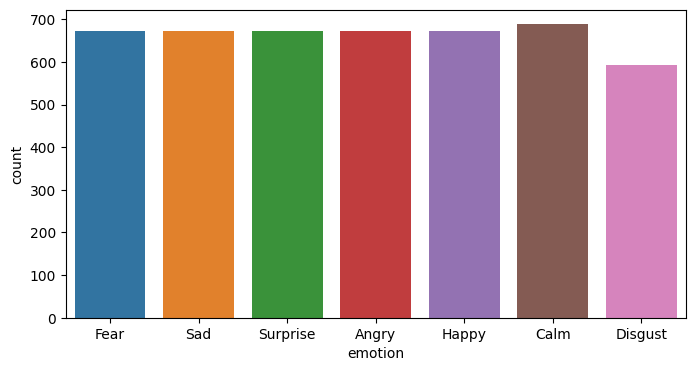

In [51]:
fig = plt.figure()
plt.figure(figsize=(8, 4))
sns.countplot(x="emotion", data=df)
plt.show();

In [48]:
df = df.replace(["Achievement"], "Happy")

In [49]:
df = df.replace(["Pain"], "Sad")

In [50]:
df['emotion'].value_counts()

Calm        688
Fear        672
Sad         672
Surprise    672
Angry       672
Happy       672
Disgust     592
Name: emotion, dtype: int64

In [8]:
df.isnull().sum()

file_path    0
emotion      0
dtype: int64

In [9]:
df['emotion'].count()

4640

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def padding(data):
    padded_data = np.pad(data, (0,200006-len(data)),'constant')
    return padded_data

def remove_noise(padded_data, sample_rate):
    return nr.reduce_noise(y=padded_data, y_noise=padded_data,sr=sample_rate)

path = np.array(df["file_path"])[0]
data, sample_rate = librosa.load(path)

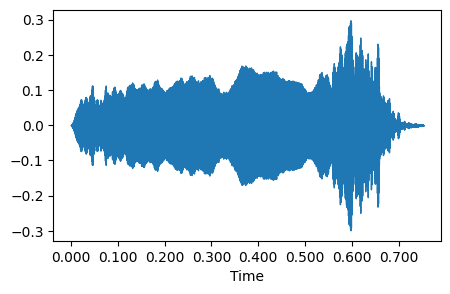

In [11]:
plt.figure(figsize=(5,3))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

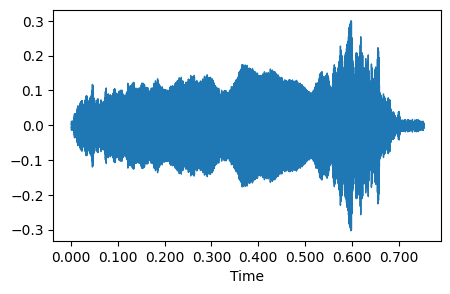

In [12]:
x = noise(data)
plt.figure(figsize=(5,3))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

C:\Users\deyna\AppData\Local\Temp\ipykernel_24996\411098541.py:10: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


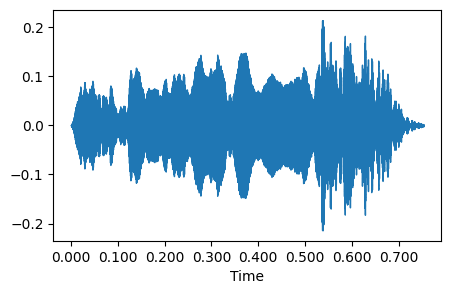

In [13]:
x = pitch(data, sample_rate)
plt.figure(figsize=(5,3))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

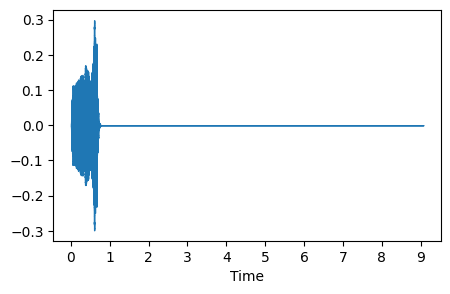

In [14]:
padded_data = padding(data)
plt.figure(figsize=(5,3))
librosa.display.waveshow(y=padded_data, sr=sample_rate)
Audio(padded_data, rate=sample_rate)

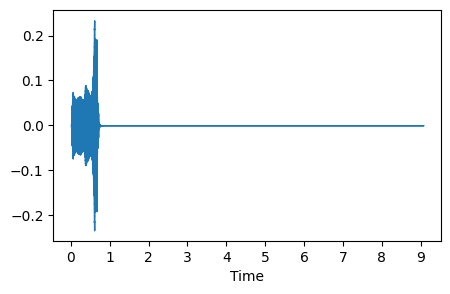

In [15]:
x = remove_noise(padded_data,sample_rate)
plt.figure(figsize=(5,3))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [16]:
# extract the MFCC features
def feature_extract(data):
    result = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T,axis=0)
    result_mfcc = np.hstack((result, mfcc))
  
    return result_mfcc

In [17]:
def get_features(data):
    data, sample_rate = librosa.load(path)
    #duration = 2.5, offset=0.6

    # the result without augmentation 
    res1 = feature_extract(data)
    result = np.array(res1)
  
  
    # data with padding and noise removal 
    padding_data = padding(data)
    noise_removal = remove_noise(padding_data, sample_rate)
  
    res3 = feature_extract(noise_removal)
    result = np.vstack((result,res3))
  
    return result

In [18]:
X, y = [], []

for path, emotion in zip(df["file_path"], df["emotion"]):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion as augmentation techniques are applied on each audio file
        y.append(emotion)

In [19]:
len(X), len(y), df["file_path"].shape

(9280, 9280, (4640,))

In [20]:
features = pd.DataFrame(X)
features['labels'] = y

features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-386.587433,-25.686150,-118.648987,-32.448090,-4.814214,31.051132,21.012894,18.496418,-7.673435,18.624300,...,16.368950,3.703465,6.141129,1.050513,2.901669,8.079653,10.054010,-9.689288,9.475249,Fear
1,-686.314270,-2.735783,-7.282777,-1.600864,-0.150740,1.738440,1.121066,0.860400,-0.754584,1.753883,...,0.834140,0.001001,-0.294498,-0.306390,0.953046,0.874974,0.141407,-1.186051,0.744662,Fear
2,-481.510773,51.840122,-42.901215,-5.248830,3.951638,0.227334,-32.942863,-2.940909,-20.605270,20.912195,...,-4.548975,7.008313,15.708561,18.058535,14.573631,13.486893,26.124773,-8.852906,5.672849,Sad
3,-826.979553,3.886588,-2.527422,0.421713,0.637408,0.089713,-3.156807,-0.044439,-1.948918,2.036234,...,-0.386924,0.941507,1.813133,1.656335,1.342922,1.097781,2.546387,-0.812368,0.582717,Sad
4,-352.372772,25.688349,-77.723984,-24.510372,-14.566017,2.770047,-6.641304,22.828054,11.823653,6.784543,...,5.269209,18.521252,19.823277,-0.003482,-5.485961,2.032882,0.994474,-2.904186,8.556024,Fear


In [21]:
X = features.iloc[: ,:-1].values # without the labels column
y = features['labels'].values

In [22]:
# this is a multiclass classification, so onehotencoding the y
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [23]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6960, 20), (6960, 7), (2320, 20), (2320, 7))

In [24]:
# scaling the data with sklearn's Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6960, 20), (6960, 7), (2320, 20), (2320, 7))

In [25]:
model_ann = Sequential()

# input and first hidden layer
model_ann.add(Dense(input_shape=(X_train.shape[1: ]), units=256, activation='relu', kernel_initializer='uniform'))
model_ann.add(Dropout(0.5))

# second hidden layer
model_ann.add(Dense(units=256,activation='relu',kernel_initializer='uniform'))
model_ann.add(Dropout(0.5))

# output layer
model_ann.add(Dense(units=7, activation='softmax'))

# compiling our model
model_ann.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [26]:
model_ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 72,967
Trainable params: 72,967
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model_ann.fit(X_train, y_train, 
                        batch_size=32, 
                        epochs=25, 
                        validation_data=(X_test,y_test), 
                        verbose=1)

Epoch 1/25
218/218 [==============================] - 1s 4ms/step - loss: 1.5075 - accuracy: 0.4461 - val_loss: 1.1602 - val_accuracy: 0.6116
Epoch 2/25
218/218 [==============================] - 1s 3ms/step - loss: 1.1373 - accuracy: 0.6059 - val_loss: 0.9728 - val_accuracy: 0.6940
Epoch 3/25
218/218 [==============================] - 1s 3ms/step - loss: 1.0040 - accuracy: 0.6539 - val_loss: 0.8708 - val_accuracy: 0.7216
Epoch 4/25
218/218 [==============================] - 1s 3ms/step - loss: 0.9237 - accuracy: 0.6708 - val_loss: 0.8142 - val_accuracy: 0.7375
Epoch 5/25
218/218 [==============================] - 1s 3ms/step - loss: 0.8723 - accuracy: 0.6849 - val_loss: 0.7677 - val_accuracy: 0.7358
Epoch 6/25
218/218 [==============================] - 1s 3ms/step - loss: 0.8293 - accuracy: 0.6984 - val_loss: 0.7426 - val_accuracy: 0.7409
Epoch 7/25
218/218 [==============================] - 1s 3ms/step - loss: 0.8121 - accuracy: 0.7065 - val_loss: 0.7251 - val_accuracy: 0.7435
Epoch 

73/73 [==============================] - 0s 1ms/step - loss: 0.5947 - accuracy: 0.7888
Accuracy of the model on test data :  78.87930870056152 %


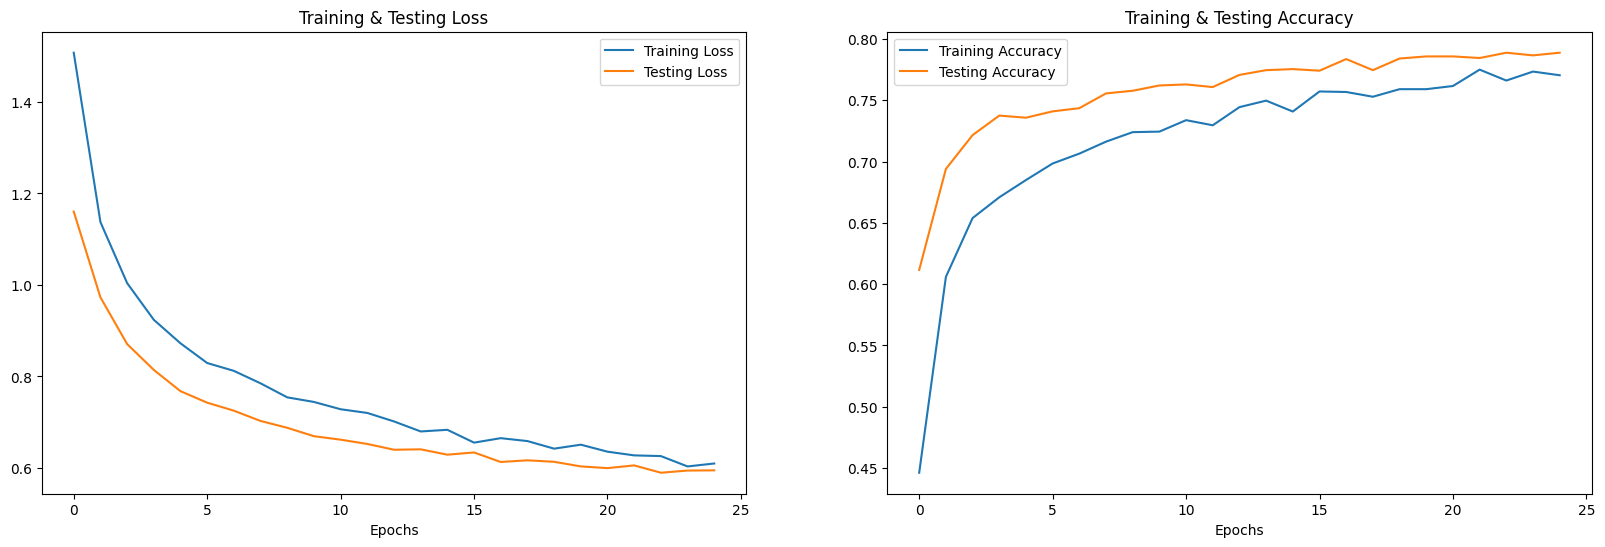

In [28]:
print("Accuracy of the model on test data : " , model_ann.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
test_acc = history.history["val_accuracy"]
test_loss = history.history["val_loss"]

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = "Training Loss")
ax[0].plot(epochs , test_loss , label = "Testing Loss")
ax[0].set_title("Training & Testing Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = "Training Accuracy")
ax[1].plot(epochs , test_acc , label = "Testing Accuracy")
ax[1].set_title("Training & Testing Accuracy")
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [29]:
# predicting on test data
pred_test = model_ann.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

73/73 [==============================] - 0s 2ms/step


In [30]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,Fear,Fear
1,Disgust,Disgust
2,Angry,Angry
3,Sad,Fear
4,Fear,Happy
5,Sad,Happy
6,Fear,Fear
7,Happy,Happy
8,Calm,Calm
9,Happy,Happy


In [52]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.tail(30)

,Predicted Labels,Actual Labels
2290,Sad,Surprise
2291,Happy,Disgust
2292,Calm,Calm
2293,Calm,Fear
2294,Happy,Surprise
2295,Angry,Angry
2296,Surprise,Surprise
2297,Calm,Calm
2298,Sad,Fear
2299,Sad,Disgust


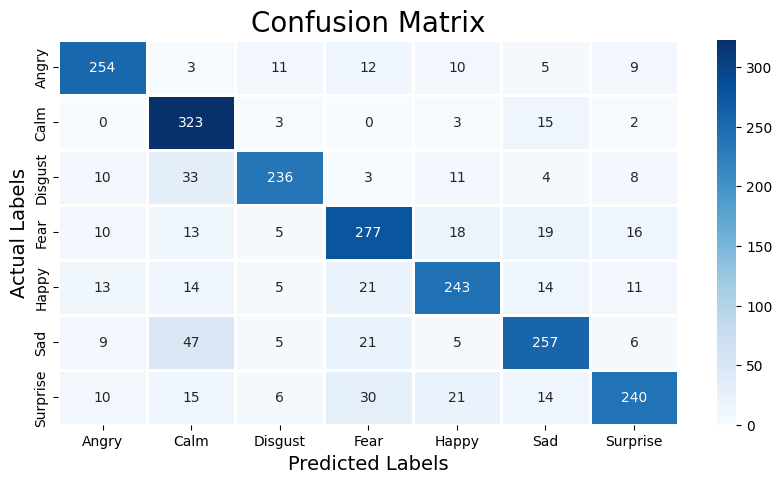

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Angry       0.83      0.84      0.83       304
        Calm       0.72      0.93      0.81       346
     Disgust       0.87      0.77      0.82       305
        Fear       0.76      0.77      0.77       358
       Happy       0.78      0.76      0.77       321
         Sad       0.78      0.73      0.76       350
    Surprise       0.82      0.71      0.76       336

    accuracy                           0.79      2320
   macro avg       0.80      0.79      0.79      2320
weighted avg       0.79      0.79      0.79      2320



In [53]:
# save model and weights
model_name = 'ANN_Model.h5'
save_dir = "../../data/"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_ann.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model_ann.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at ../../data/ANN_Model.h5 
